In [1]:
import torch
import torchvision
from torchvision import models, transforms
from matplotlib import pyplot as plt
import numpy as np
import os
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from PIL import Image

>>>>>>>>>>>INTERACT HERE

>>>>>>>>>>>>>>>>>>RUN ALL

In [2]:
testing_folder = '/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/dataset/test'
testing_catagory_list = os.listdir(testing_folder)
if '.DS_Store' in testing_catagory_list:
    testing_catagory_list.remove('.DS_Store')
first_catagory = os.path.join(testing_folder, testing_catagory_list[0])
testing_image_list = os.listdir(first_catagory)
if '.DS_Store' in testing_image_list:
    testing_image_list.remove('.DS_Store')
first_image = os.path.join(first_catagory, testing_image_list[0])
testing_image = Image.open(first_image)
size = testing_image.size
if size[0] > size[1]:
    min_size = size[1]
else:
    min_size = size[0]
print(min_size)

1080


In [3]:
data_transforms = {
    'test': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.CenterCrop(min_size),
        transforms.RandomHorizontalFlip(),
        transforms.Grayscale(),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [5]:
def visualize(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]

In [6]:
def visualize_wimg(model, img_path):
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = data_transforms['test'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])
    return class_names[preds[0]]

In [20]:
def confusion_matrix(model, folder_path):
    catagories = os.listdir(folder_path)
    if '.DS_Store' in catagories:
        catagories.remove('.DS_Store')
    num_catagories = len(catagories)
    #import confusion matrix
    value_library = {}
    confusion_matrix = np.zeros((num_catagories, num_catagories))
    catagory_list = os.listdir(folder_path)
    if '.DS_Store' in catagory_list:
        catagory_list.remove('.DS_Store')
    for catagory in catagory_list:
        catagory_path = os.path.join(folder_path, catagory)
        img_list = os.listdir(catagory_path)
        if '.DS_Store' in img_list:
            img_list.remove('.DS_Store')
        
        #shuffle order of img_list
        np.random.shuffle(img_list)
        for img in img_list:
            img_path = os.path.join(catagory_path, img)
            predicted = visualize(model, img_path)
            predicted_index = catagory_list.index(predicted)
            actual_index = catagory_list.index(catagory)
            if predicted_index != actual_index:
                visualize_wimg(model,img_path)
                print('Predicted Identity: ', predicted, ' index: ', predicted_index)
                print('Actual Identity: ', catagory, ' actual index: ', actual_index)
            confusion_matrix[actual_index][predicted_index] += 1
            
    for catagory in catagory_list:
        catagory_index = catagory_list.index(catagory)
        true_positive = confusion_matrix[catagory_index][catagory_index]
        false_negative = confusion_matrix[catagory_index][:].sum() - true_positive
        num = 0
        for row in confusion_matrix:
            num = num + row[catagory_index]
        false_positive = num - true_positive
        
        true_negative = confusion_matrix[:][:].sum() - confusion_matrix[catagory_index][:].sum() - confusion_matrix[:][catagory_index].sum() + confusion_matrix[catagory_index][catagory_index]
        values = {}
        values['true_positive'] = true_positive
        values['true_negative'] = true_negative
        values['false_positive'] = false_positive
        values['false_negative'] = false_negative
        value_library[catagory] = values
    return value_library



In [8]:
def confusion_matrix_2cat(model, folder_path):
    num_catagories = len(os.listdir(folder_path))
    value_library = {}
    confusion_matrix = np.zeros((num_catagories, num_catagories))
    catagory_list = os.listdir(folder_path)
    for catagory in catagory_list:
        catagory_path = os.path.join(folder_path, catagory)
        img_list = os.listdir(catagory_path)
        for img in img_list:
            img_path = os.path.join(catagory_path, img)
            predicted = visualize(model, img_path)
            predicted_index = catagory_list.index(predicted)
            actual_index = catagory_list.index(catagory)
            
            confusion_matrix[actual_index][predicted_index] += 1
            #write functions to calculate true positive, true negative, false positive, false negative
    for catagory in catagory_list:
        catagory_index = catagory_list.index(catagory)
        true_positive = confusion_matrix[catagory_index][catagory_index]
        if catagory_index == 0:
            false_negative = confusion_matrix[catagory_index][catagory_index+1]
        if catagory_index == 1:
            false_negative = confusion_matrix[catagory_index][catagory_index-1]
        false_positive = confusion_matrix[:][catagory_index].sum() - true_positive
        true_negative = confusion_matrix[:][:].sum() - confusion_matrix[catagory_index][:].sum() - confusion_matrix[:][catagory_index].sum() + confusion_matrix[catagory_index][catagory_index]
        values = {}
        values['true_positive'] = true_positive
        values['true_negative'] = true_negative
        values['false_positive'] = false_positive
        values['false_negative'] = false_negative
        value_library[catagory] = values
    return value_library
 

In [9]:
def evaluation_metrics(value_library):
    evaluation_metrics = {}
    for catagory in value_library:
        values = value_library[catagory]
        true_positive = values['true_positive']
        true_negative = values['true_negative']
        false_positive = values['false_positive']
        false_negative = values['false_negative']
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * ((precision * recall) / (precision + recall))
        evaluation_metrics[catagory] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1_score}
    return evaluation_metrics


In [10]:
def average_evaluation_metrics(evaluation_metrics):
    average_evaluation_metrics = {}
    accuracy = 0
    precision = 0
    recall = 0
    f1_score = 0
    for catagory in evaluation_metrics:
        values = evaluation_metrics[catagory]
        accuracy += values['accuracy']
        precision += values['precision']
        recall += values['recall']
        f1_score += values['f1_score']
    average_evaluation_metrics['accuracy'] = accuracy / len(evaluation_metrics)
    average_evaluation_metrics['precision'] = precision / len(evaluation_metrics)
    average_evaluation_metrics['recall'] = recall / len(evaluation_metrics)
    average_evaluation_metrics['f1_score'] = f1_score / len(evaluation_metrics)
    return average_evaluation_metrics


In [11]:
def visualize_eval(value_library, evaluation_metric_lib, average_evaluation_metrics_lib):
    print('\n' +'\n' +'~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    for value in value_library:
        print(value + ':')
        print(value_library[value])
        print('catagory metrics: ')
        print(evaluation_metric_lib[value])
        print ('\n')
    print('########################################')
    print('average evaluation metrics: ')
    for val in average_evaluation_metrics_lib:
        print(val + ': ' + str(average_evaluation_metrics_lib[val]))
    print('########################################')

In [12]:
def evaluate(model, folder_path, cat_num):
    if cat_num == 2:
        value_library = confusion_matrix_2cat(model, folder_path)
    else:
        value_library = confusion_matrix(model, folder_path)
    evaluation_metric_lib = evaluation_metrics(value_library)
    average_evaluation_metrics_lib = average_evaluation_metrics(evaluation_metric_lib)
    visualize_eval(value_library, evaluation_metric_lib, average_evaluation_metrics_lib)
    return average_evaluation_metrics_lib

>>>>>>>>>>>>>INTERACT HERE

In [13]:
path_to_model = '/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/trial4_docs/model4.0.pt'
path_to_folder = '/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/dataset/test'

In [14]:
class_names = os.listdir(path_to_folder)
class_names.sort()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.jit.load(path_to_model)
print(class_names)

['laying', 'sitting', 'standing']


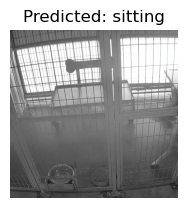

Actual Identity:  standing


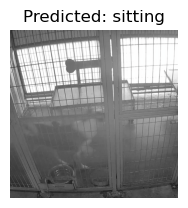

Actual Identity:  standing


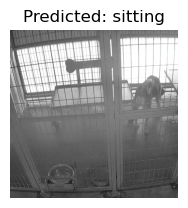

Actual Identity:  standing


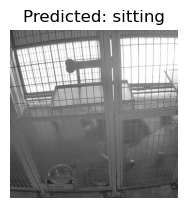

Actual Identity:  standing


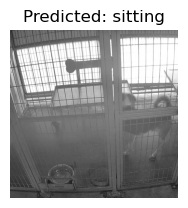

Actual Identity:  standing


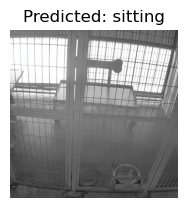

Actual Identity:  standing


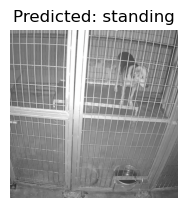

Actual Identity:  standing


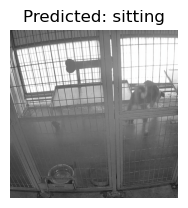

Actual Identity:  standing


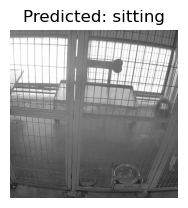

Actual Identity:  standing


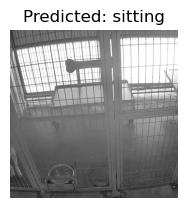

Actual Identity:  standing


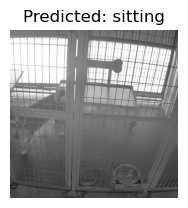

Actual Identity:  standing


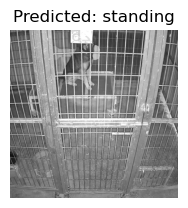

Actual Identity:  sitting


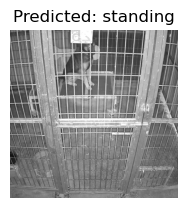

Actual Identity:  sitting


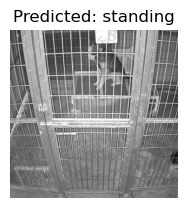

Actual Identity:  sitting


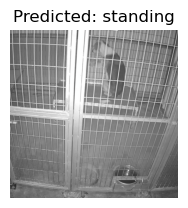

Actual Identity:  sitting


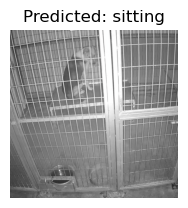

Actual Identity:  sitting


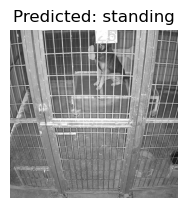

Actual Identity:  sitting


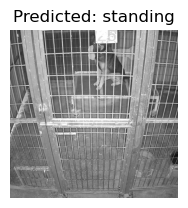

Actual Identity:  sitting


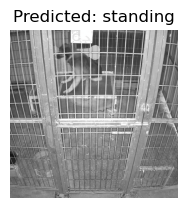

Actual Identity:  sitting


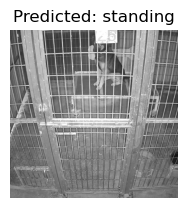

Actual Identity:  sitting


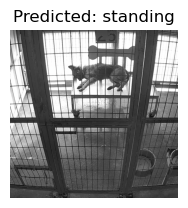

Actual Identity:  laying


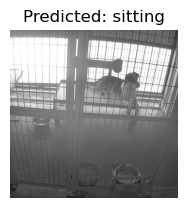

Actual Identity:  laying


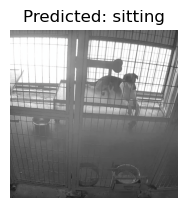

Actual Identity:  laying


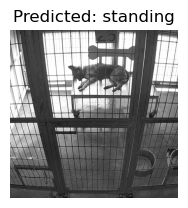

Actual Identity:  laying


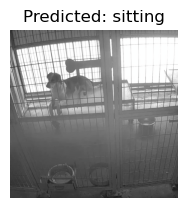

Actual Identity:  laying


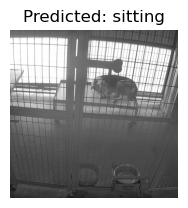

Actual Identity:  laying


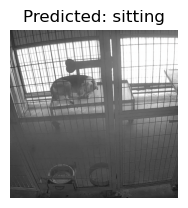

Actual Identity:  laying


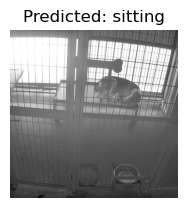

Actual Identity:  laying


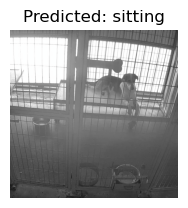

Actual Identity:  laying


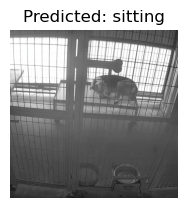

Actual Identity:  laying


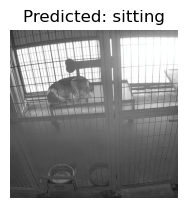

Actual Identity:  laying


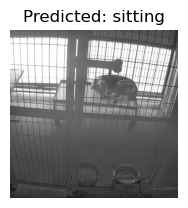

Actual Identity:  laying


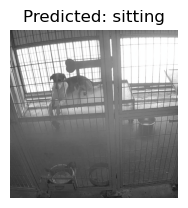

Actual Identity:  laying


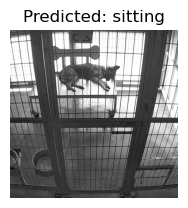

Actual Identity:  laying


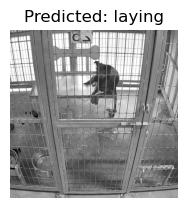

Actual Identity:  laying


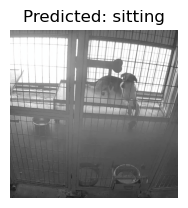

Actual Identity:  laying


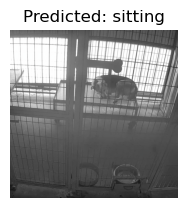

Actual Identity:  laying


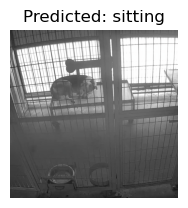

Actual Identity:  laying


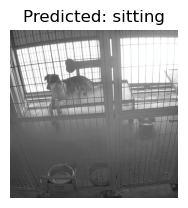

Actual Identity:  laying


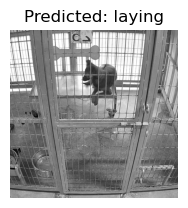

Actual Identity:  laying


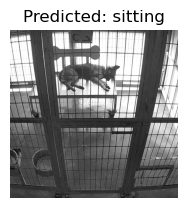

Actual Identity:  laying


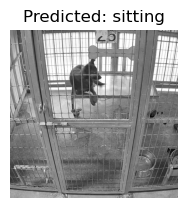

Actual Identity:  laying


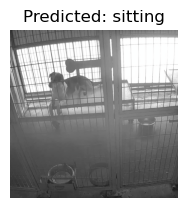

Actual Identity:  laying


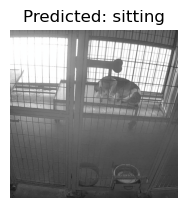

Actual Identity:  laying


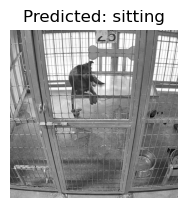

Actual Identity:  laying
[17. 11.  0.]
[17. 11.  0.]
false_positive 13.0
false negative 11.0
[[17. 11.  0.]
 [ 9. 20.  0.]
 [ 4. 21. 14.]]
[ 9. 20.  0.]
[ 9. 20.  0.]
false_positive 32.0
false negative 9.0
[[17. 11.  0.]
 [ 9. 20.  0.]
 [ 4. 21. 14.]]
[ 4. 21. 14.]
[ 4. 21. 14.]
false_positive 0.0
false negative 25.0
[[17. 11.  0.]
 [ 9. 20.  0.]
 [ 4. 21. 14.]]


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 17.0, 'true_negative': 57.0, 'false_positive': 13.0, 'false_negative': 11.0}
catagory metrics: 
{'accuracy': 0.7551020408163265, 'precision': 0.5666666666666667, 'recall': 0.6071428571428571, 'f1_score': 0.5862068965517241}


sitting:
{'true_positive': 20.0, 'true_negative': 58.0, 'false_positive': 32.0, 'false_negative': 9.0}
catagory metrics: 
{'accuracy': 0.6554621848739496, 'precision': 0.38461538461538464, 'recall': 0.6896551724137931, 'f1_score': 0.4938271604938272}


laying:
{'true_positive': 14.0, 'true_negative': 32.0, 'false_p

{'accuracy': 0.6861505165446461,
 'precision': 0.6504273504273504,
 'recall': 0.5519241295103364,
 'f1_score': 0.5361119812793347}

In [15]:
evaluate(model, path_to_folder, 3)

>>>>>>NEW MODEL SET

In [16]:
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/trial4_docs/model4.1.pt')


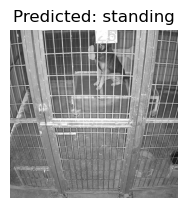

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


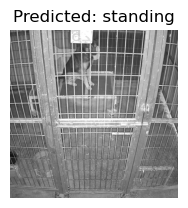

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


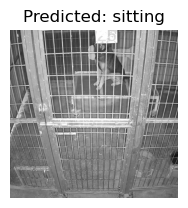

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


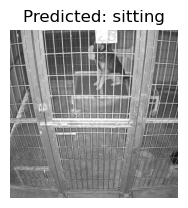

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


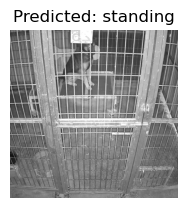

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


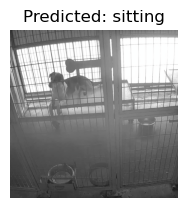

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


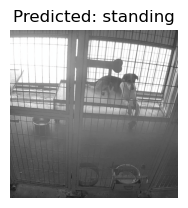

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


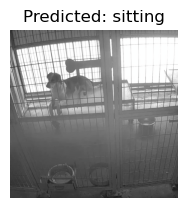

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


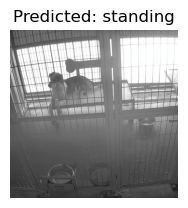

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


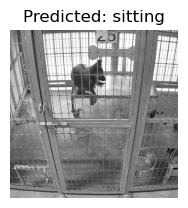

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


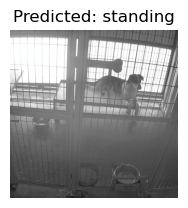

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


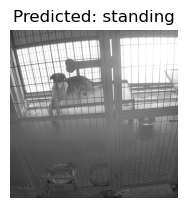

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 28.0, 'true_negative': 68.0, 'false_positive': 9.0, 'false_negative': 0.0}
catagory metrics: 
{'accuracy': 0.9142857142857143, 'precision': 0.7567567567567568, 'recall': 1.0, 'f1_score': 0.8615384615384616}


sitting:
{'true_positive': 24.0, 'true_negative': 62.0, 'false_positive': 3.0, 'false_negative': 5.0}
catagory metrics: 
{'accuracy': 0.9148936170212766, 'precision': 0.8888888888888888, 'recall': 0.8275862068965517, 'f1_score': 0.8571428571428572}


laying:
{'true_positive': 32.0, 'true_negative': 50.0, 'false_positive': 0.0, 'false_negative': 7.0}
catagory metrics: 
{'accuracy': 0.9213483146067416, 'precision': 1.0, 'recall': 0.8205128205128205, 'f1_score': 0.9014084507042254}


########################################
average evaluation metrics: 
accuracy: 0.9168425486379107
precision: 0.8818818818818818

{'accuracy': 0.9168425486379107,
 'precision': 0.8818818818818818,
 'recall': 0.8826996758031239,
 'f1_score': 0.8733632564618481}

In [21]:
evaluate(model, path_to_folder,3)

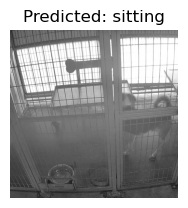

Predicted Identity:  sitting  index:  1
Actual Identity:  standing  actual index:  0


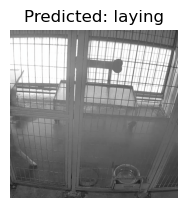

Predicted Identity:  laying  index:  2
Actual Identity:  standing  actual index:  0


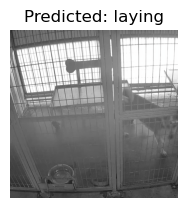

Predicted Identity:  laying  index:  2
Actual Identity:  standing  actual index:  0


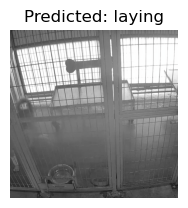

Predicted Identity:  laying  index:  2
Actual Identity:  standing  actual index:  0


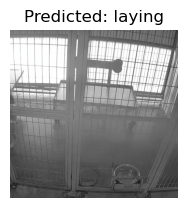

Predicted Identity:  laying  index:  2
Actual Identity:  standing  actual index:  0


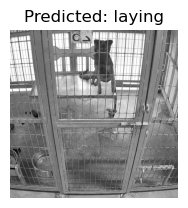

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


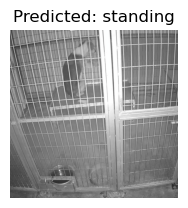

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


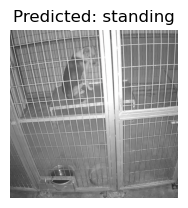

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


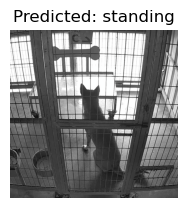

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


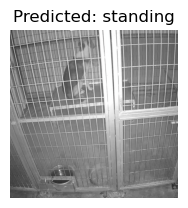

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


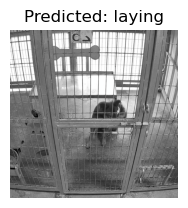

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


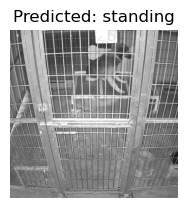

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


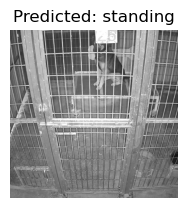

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


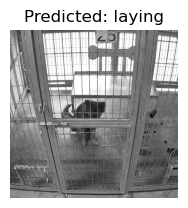

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


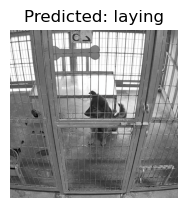

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


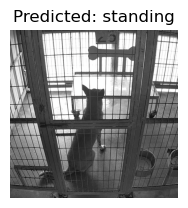

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


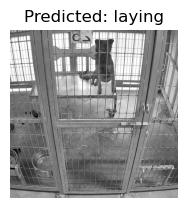

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


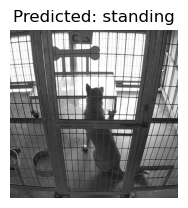

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


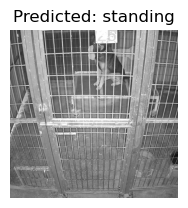

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


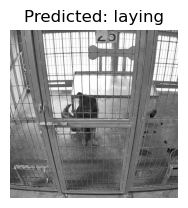

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


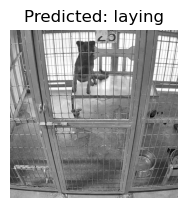

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


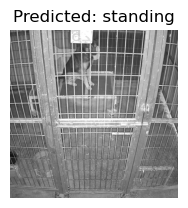

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


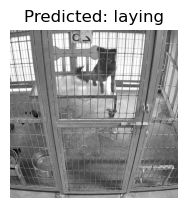

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


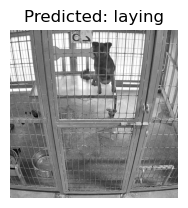

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


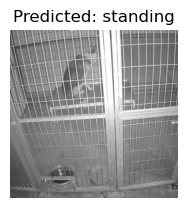

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


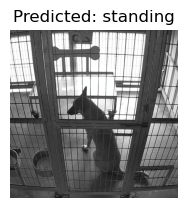

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


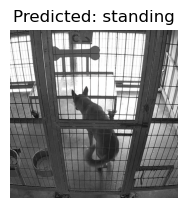

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


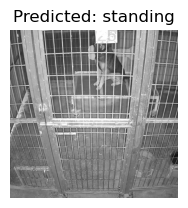

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


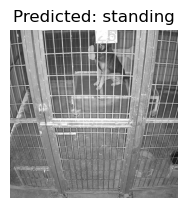

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


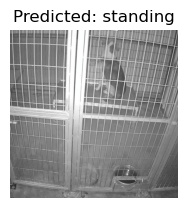

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


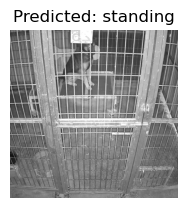

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


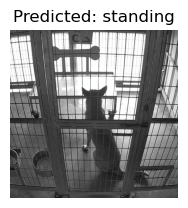

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


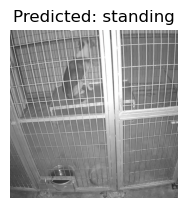

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


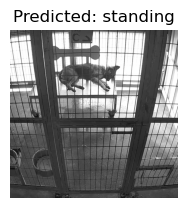

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


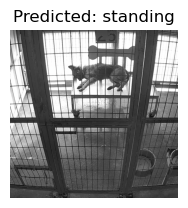

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


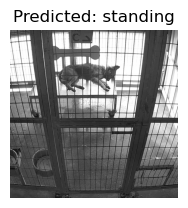

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


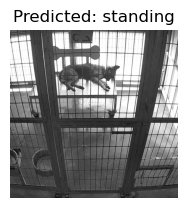

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 23.0, 'true_negative': 63.0, 'false_positive': 23.0, 'false_negative': 5.0}
catagory metrics: 
{'accuracy': 0.7543859649122807, 'precision': 0.5, 'recall': 0.8214285714285714, 'f1_score': 0.6216216216216216}


sitting:
{'true_positive': 1.0, 'true_negative': 39.0, 'false_positive': 1.0, 'false_negative': 28.0}
catagory metrics: 
{'accuracy': 0.5797101449275363, 'precision': 0.5, 'recall': 0.034482758620689655, 'f1_score': 0.06451612903225806}


laying:
{'true_positive': 35.0, 'true_negative': 53.0, 'false_positive': 13.0, 'false_negative': 4.0}
catagory metrics: 
{'accuracy': 0.8380952380952381, 'precision': 0.7291666666666666, 'recall': 0.8974358974358975, 'f1_score': 0.8045977011494253}


########################################
average evaluation metrics: 
accuracy: 0.7240637826450184
precision: 0.57638888888

{'accuracy': 0.7240637826450184,
 'precision': 0.5763888888888888,
 'recall': 0.5844490758283861,
 'f1_score': 0.4969118172677683}

In [22]:
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/trial4_docs/model4.2.pt')
evaluate(model, path_to_folder,3)

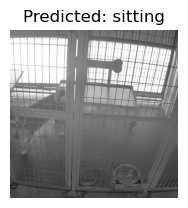

Predicted Identity:  sitting  index:  1
Actual Identity:  standing  actual index:  0


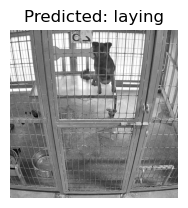

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


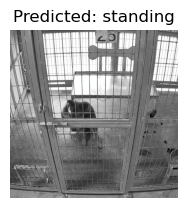

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


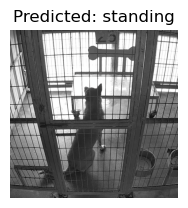

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


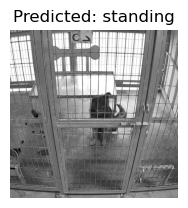

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


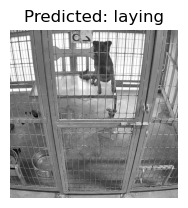

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


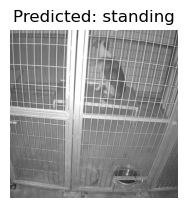

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


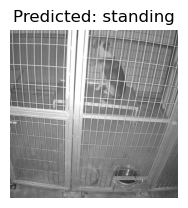

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


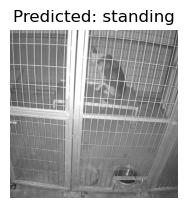

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


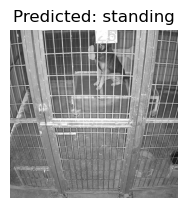

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


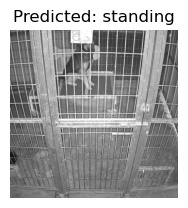

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


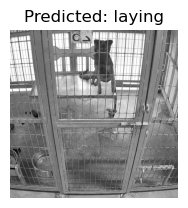

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


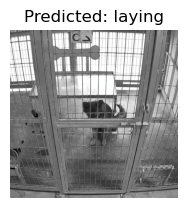

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


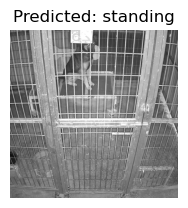

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


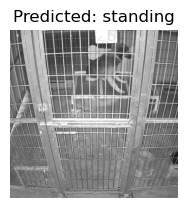

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


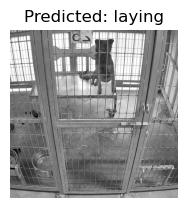

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


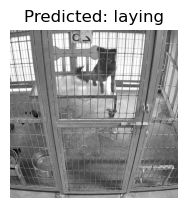

Predicted Identity:  laying  index:  2
Actual Identity:  sitting  actual index:  1


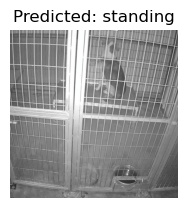

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


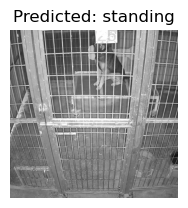

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


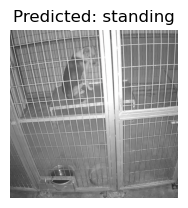

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


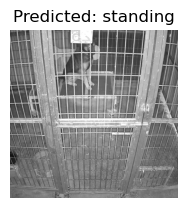

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


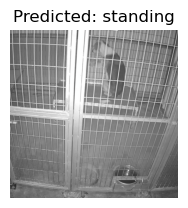

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


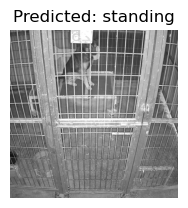

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


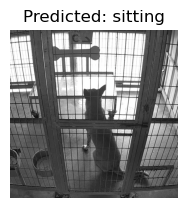

Predicted Identity:  standing  index:  0
Actual Identity:  sitting  actual index:  1


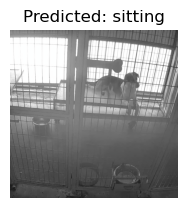

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


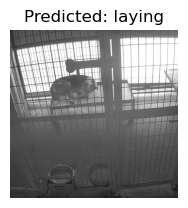

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


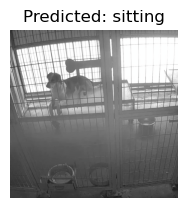

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


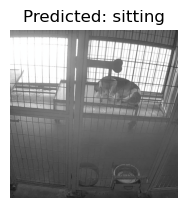

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


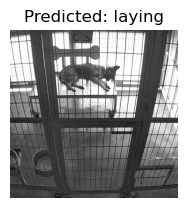

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


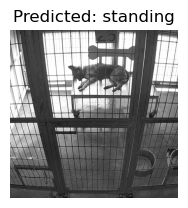

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


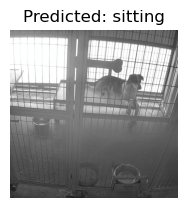

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


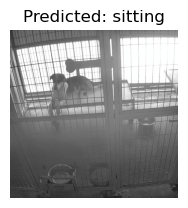

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


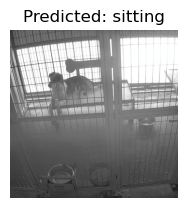

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


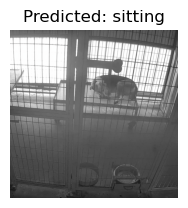

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


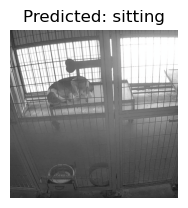

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


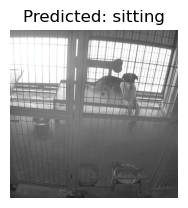

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


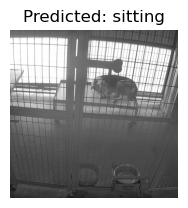

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


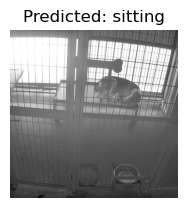

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


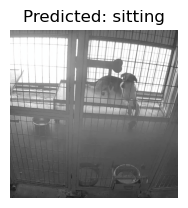

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


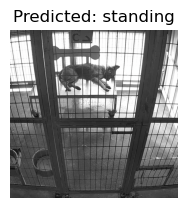

Predicted Identity:  standing  index:  0
Actual Identity:  laying  actual index:  2


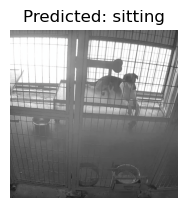

Predicted Identity:  sitting  index:  1
Actual Identity:  laying  actual index:  2


~~~~~~~~~~~~~~~~~~~~~~~EVALUATION~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
standing:
{'true_positive': 27.0, 'true_negative': 67.0, 'false_positive': 20.0, 'false_negative': 1.0}
catagory metrics: 
{'accuracy': 0.8173913043478261, 'precision': 0.574468085106383, 'recall': 0.9642857142857143, 'f1_score': 0.7200000000000001}


sitting:
{'true_positive': 6.0, 'true_negative': 44.0, 'false_positive': 15.0, 'false_negative': 23.0}
catagory metrics: 
{'accuracy': 0.5681818181818182, 'precision': 0.2857142857142857, 'recall': 0.20689655172413793, 'f1_score': 0.24000000000000002}


laying:
{'true_positive': 22.0, 'true_negative': 40.0, 'false_positive': 6.0, 'false_negative': 17.0}
catagory metrics: 
{'accuracy': 0.7294117647058823, 'precision': 0.7857142857142857, 'recall': 0.5641025641025641, 'f1_score': 0.6567164179104477}


########################################
average evaluation metrics: 
accuracy: 0.7049949624118

{'accuracy': 0.7049949624118422,
 'precision': 0.5486322188449848,
 'recall': 0.5784282767041388,
 'f1_score': 0.538905472636816}

In [23]:
model = torch.jit.load('/Users/david/Desktop/shelter_dogs_research/Trials/trial4_raw/trial4_docs/model4.3.pt')
evaluate(model, path_to_folder,3)